In [302]:
# imports and setup
import pandas as pd
import numpy as np
import nltk
import stanza
import re
# from nltk.corpus import stopwords, wordnet
# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from operator import itemgetter
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

pattern = r'[^A-Za-z0-9]+'

In [184]:
# import corpora
stanza.download('en')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

2022-11-07 15:00:13 INFO: Downloading default packages for language: en (English) ...
2022-11-07 15:00:14 INFO: File exists: C:\Users\krish\stanza_resources\en\default.zip
2022-11-07 15:00:17 INFO: Finished downloading models and saved to C:\Users\krish\stanza_resources.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [185]:
# initialise nlp pipeline
nlp = stanza.Pipeline()
sid = SentimentIntensityAnalyzer()

2022-11-07 15:00:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-07 15:00:19 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-11-07 15:00:19 INFO: Use device: cpu
2022-11-07 15:00:19 INFO: Loading: tokenize
2022-11-07 15:00:19 INFO: Loading: pos
2022-11-07 15:00:19 INFO: Loading: lemma
2022-11-07 15:00:19 INFO: Loading: depparse
2022-11-07 15:00:19 INFO: Loading: sentiment
2022-11-07 15:00:19 INFO: Loading: constituency
2022-11-07 15:00:19 INFO: Loading: ner
2022-11-07 15:00:20 INFO: Done loading processors!


In [304]:
# define some nice plot colours
colors = ['#142459', '#176BA0', '#19AADE', '#1AC9E6', '#1DE4BD', '#60F0D2', '#c7F9EE']

In [186]:
reviews = pd.read_csv('data/Books_rating.csv')

In [188]:
# check first n rows of review text
reviews[['review/text', 'review/score']].iloc[:10]

,review/text,review/score
0,This is only for Julie Strain fans. It's a col...,4.0
1,I don't care much for Dr. Seuss but after read...,5.0
2,"If people become the books they read and if ""t...",5.0
3,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",4.0
4,Philip Nel - Dr. Seuss: American IconThis is b...,4.0
5,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",4.0
6,Theodor Seuss Giesel was best known as 'Dr. Se...,5.0
7,When I recieved this book as a gift for Christ...,5.0
8,Trams (or any public transport) are not usuall...,5.0
9,"As far as I am aware, this is the first book-l...",4.0


In [286]:
# set number of rows:
n = 100
aspects = 7

In [287]:
# lowercase and tokenise
data = reviews[['review/text', 'review/score']].iloc[:n].apply(lambda x: x.astype(str).str.lower())
sentence_tokenized = data['review/text'].apply(nltk.sent_tokenize)

In [288]:
def clean_sentence(sentence):
    clean_sentence = re.sub(pattern, ' ', sentence)
    token_clean = nltk.word_tokenize(clean_sentence)
    pos_clean = nltk.pos_tag(token_clean)
    return(pos_clean, clean_sentence, token_clean)

In [289]:
# tokenize data
review_list = []

for review in sentence_tokenized:
    sentence_clean = []
    sentence_pos = []
    sentence_token = []
    for sentence in review:
        pos, clean, token = clean_sentence(sentence)
        sentence_pos.append(pos)
        sentence_clean.append(clean)
        sentence_token.append(token)
    review_dict = {"sentence": sentence_clean, "token": sentence_token, "pos": sentence_pos}
    review_list.append(review_dict)

In [290]:
# put tokenized data in dataframe
tokenized_data = pd.DataFrame(review_list)   
tokenized_data['scores'] = None
tokenized_data['duration'] = 0
tokenized_data = pd.concat([tokenized_data, data['review/score']], axis=1, join='inner')
tokenized_data.head()

,sentence,token,pos,scores,duration,review/score
0,"[this is only for julie strain fans , it s a c...","[[this, is, only, for, julie, strain, fans], [...","[[(this, DT), (is, VBZ), (only, RB), (for, IN)...",None,0,4.0
1,[i don t care much for dr seuss but after read...,"[[i, don, t, care, much, for, dr, seuss, but, ...","[[(i, JJ), (don, VBP), (t, EX), (care, NN), (m...",None,0,5.0
2,[if people become the books they read and if t...,"[[if, people, become, the, books, they, read, ...","[[(if, IN), (people, NNS), (become, VBP), (the...",None,0,5.0
3,[theodore seuss geisel 1904 1991 aka quot dr s...,"[[theodore, seuss, geisel, 1904, 1991, aka, qu...","[[(theodore, RB), (seuss, JJ), (geisel, NN), (...",None,0,4.0
4,[philip nel dr seuss american iconthis is basi...,"[[philip, nel, dr, seuss, american, iconthis, ...","[[(philip, NN), (nel, NNS), (dr, VBP), (seuss,...",None,0,4.0


In [291]:
def sentiment_score(finalcluster):
    scores = []
    for pair in finalcluster:
        # only look at valid pairs
        if len(pair[1]) != 0:
            score = sid.polarity_scores(''.join(pair[1]))
            if score['compound'] != 0.0:
                pair_score = [pair, score['compound']]
                scores.append(pair_score)
    return(scores)

In [292]:
def find_relationships(doc, token, pos):
    # categories = []
    if doc.sentences[0].dependencies:
        dep_node = []
        # print(dep_node)
        for dep in doc.sentences[0].dependencies:
            dep_node.append([dep[2].text, dep[0].id, dep[1]])
        for i in range(0, len(dep_node)):
            if (int(dep_node[i][1]) != 0):
                dep_node[i][1] = token[(int(dep_node[i][1]) - 1)]
                
        # possible features
        featureList = []
        for i in pos:
            if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
                featureList.append(list(i))

        # cluster together features and descriptors
        fcluster = []
        for i in featureList:
            filist = []
            for j in dep_node:
                if((j[0]==i[0] or j[1]==i[0]) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(j[0]==i[0]):
                        filist.append(j[1])
                    else:
                        filist.append(j[0])
            fcluster.append([i[0], filist])

        # select only nouns
        finalcluster = []
        dic = {}
        for i in featureList:
            dic[i[0]] = i[1]
        for i in fcluster:
            if(dic[i[0]]=="NN"):
                finalcluster.append(i)

        # get sentence scores  
        sentence_sentiment = sentiment_score(finalcluster) 
        # for score in sentence_sentiment:
        #     sentence_scores.append(score)
    return(sentence_sentiment)

In [293]:
def get_aspects(scores):
    aspects = []
    for x in scores:
        for y in x:
            aspects.append([y[0][0], y[0][1][0], y[1]])
    return(aspects)

In [294]:
def absa(tokenized_data, aspects = aspects, n = n):
    # loop through data
    #reviews
    for i in tqdm(range(0, n)):
        start_review = time.time()
        current_aspects = 0
        # sentences
        review_scores = []
        for j in range(0, len(tokenized_data['sentence'].loc[i]) - 1):
            current_aspects = len(review_scores)
            if current_aspects >= aspects:
                continue
            sentence = tokenized_data['sentence'].loc[i][j]
            pos = tokenized_data['pos'].loc[i][j]
            token = tokenized_data['token'].loc[i][j] 
            if len(sentence.strip()) == 0:
                continue
            else:
                # print(sentence)
                doc = nlp(sentence)
                try:
                    scores = find_relationships(doc, token, pos)
                    # print(scores)
                    if len(scores) != 0:
                        review_scores.append(scores)
                except:
                    continue
            # limit number of aspects processed
        tokenized_data['scores'].iloc[i] = review_scores[0:aspects]     
        duration = time.time() - start_review
        tokenized_data['duration'].loc[i] = duration  
        # break
    return(tokenized_data.iloc[:n])

In [295]:
output = absa(tokenized_data = tokenized_data, aspects = aspects, n = n)
output.to_csv('data/output(n' + str(n) + '_a' + str(aspects) + ').csv')
print('done!')

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\krish\AppData\Local\Temp\ipykernel_14072\2522489009.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokenized_data['scores'].iloc[i] = review_scores[0:aspects]
c:\Users\krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
C:\Users\krish\AppData\Local\Temp\ipykernel_14072\2522489009.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

done!


In [296]:
def predict(scores):
    prediction = None
    prediction_sum = 0
    #scores = list(output['scores'].loc[1]
    for x in scores:
        prediction_sum += float(x[2])
        if prediction_sum > 0:
            prediction = 'Positive'
        elif prediction_sum < 0:
            prediction = 'Negative'
        else:
            prediction = 'Neutral'
    return(prediction)

In [297]:
# format and measure output
try:
    output['review/score'] = output['review/score'].apply(lambda x: int(x.replace('.0', '')))
except:
    print('already converted to int!')
output['label'] = np.where(output['review/score'] >= 3, 'Positive', 'Negative')
output['label'] = np.where(output['review/score'] == 3, 'Neutral', output['label'])
try:
    output['scores'] = output['scores'].apply(get_aspects)
except:
    print('aspects already found!')
output['prediction'] = output['scores'].apply(predict)
output['correct'] = np.where(output['label'] == output['prediction'], 1, 0)
output.head()

,sentence,token,pos,scores,duration,review/score,label,prediction,correct
0,"[this is only for julie strain fans , it s a c...","[[this, is, only, for, julie, strain, fans], [...","[[(this, DT), (is, VBZ), (only, RB), (for, IN)...","[[julie, strain, -0.0516]]",0.158018,4,Positive,Negative,0
1,[i don t care much for dr seuss but after read...,"[[i, don, t, care, much, for, dr, seuss, but, ...","[[(i, JJ), (don, VBP), (t, EX), (care, NN), (m...","[[rel, plays, 0.25], [poet, serious, -0.0772]]",3.065648,5,Positive,Positive,1
2,[if people become the books they read and if t...,"[[if, people, become, the, books, they, read, ...","[[(if, IN), (people, NNS), (become, VBP), (the...","[[daddy, treat, 0.4019], [treatment, serious, ...",4.051847,5,Positive,Positive,1
3,[theodore seuss geisel 1904 1991 aka quot dr s...,"[[theodore, seuss, geisel, 1904, 1991, aka, qu...","[[(theodore, RB), (seuss, JJ), (geisel, NN), (...","[[semitism, anti, -0.3182], [lorax, protest, -...",7.642825,4,Positive,Positive,1
4,[philip nel dr seuss american iconthis is basi...,"[[philip, nel, dr, seuss, american, iconthis, ...","[[(philip, NN), (nel, NNS), (dr, VBP), (seuss,...","[[background, enjoy, 0.4939]]",3.642616,4,Positive,Positive,1


In [299]:
sum(output['correct'])

55

In [300]:
time_series = output['duration'].cumsum()
time_series

0       0.158018
1       3.223666
2       7.275513
3      14.918338
4      18.560954
         ...    
95    172.737540
96    174.551229
97    174.846720
98    179.747178
99    182.557342
Name: duration, Length: 100, dtype: float64

Text(0.5, 1.0, 'Number of reviews per day')

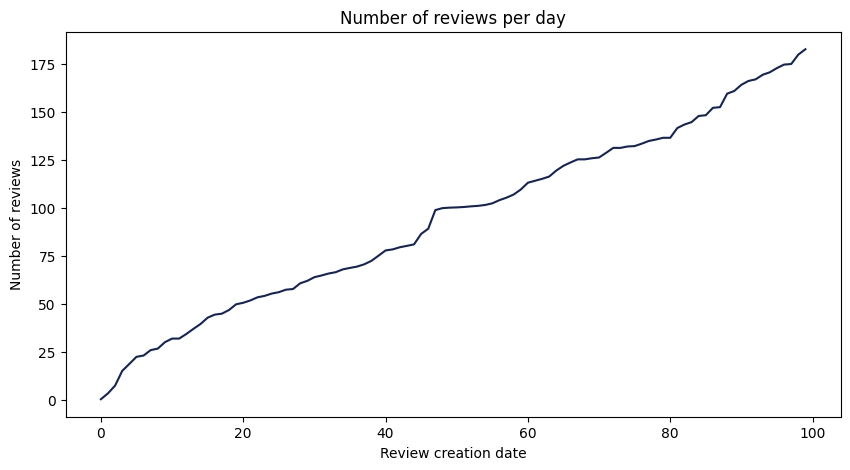

In [305]:
# Time series of daily reviews
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_series, color = colors[0])
ax.set_ylabel('Number of reviews')
ax.set_xlabel('Review creation date')
ax.set_title('Number of reviews per day')
# print('Max reviews per day: ', max(daily_reviews))